<a href="https://www.kaggle.com/code/mcchang002/cnn-categorization-test-for-tomato-leaf-classifier?scriptVersionId=211967811" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
import matplotlib.pyplot as plt
import keras
import seaborn as sns
from keras.applications import EfficientNetB3
import numpy as np
from sklearn.metrics import confusion_matrix
import zipfile
import os

import kagglehub

# Download latest version
path = kagglehub.dataset_download("kaustubhb999/tomatoleaf")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomatoleaf


In [2]:
IMG_SIZE=130
BATCH_SIZE=32
CHANNELS=3
EPOCHS=20
INPUT_SHAPE = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS)
N_CLASSES = 10

In [3]:
training= tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/train",
    seed=123,
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/tomatoleaf/tomato/val",
    seed=123,
    shuffle=False,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [4]:
classes_name=training.class_names
classes_name

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

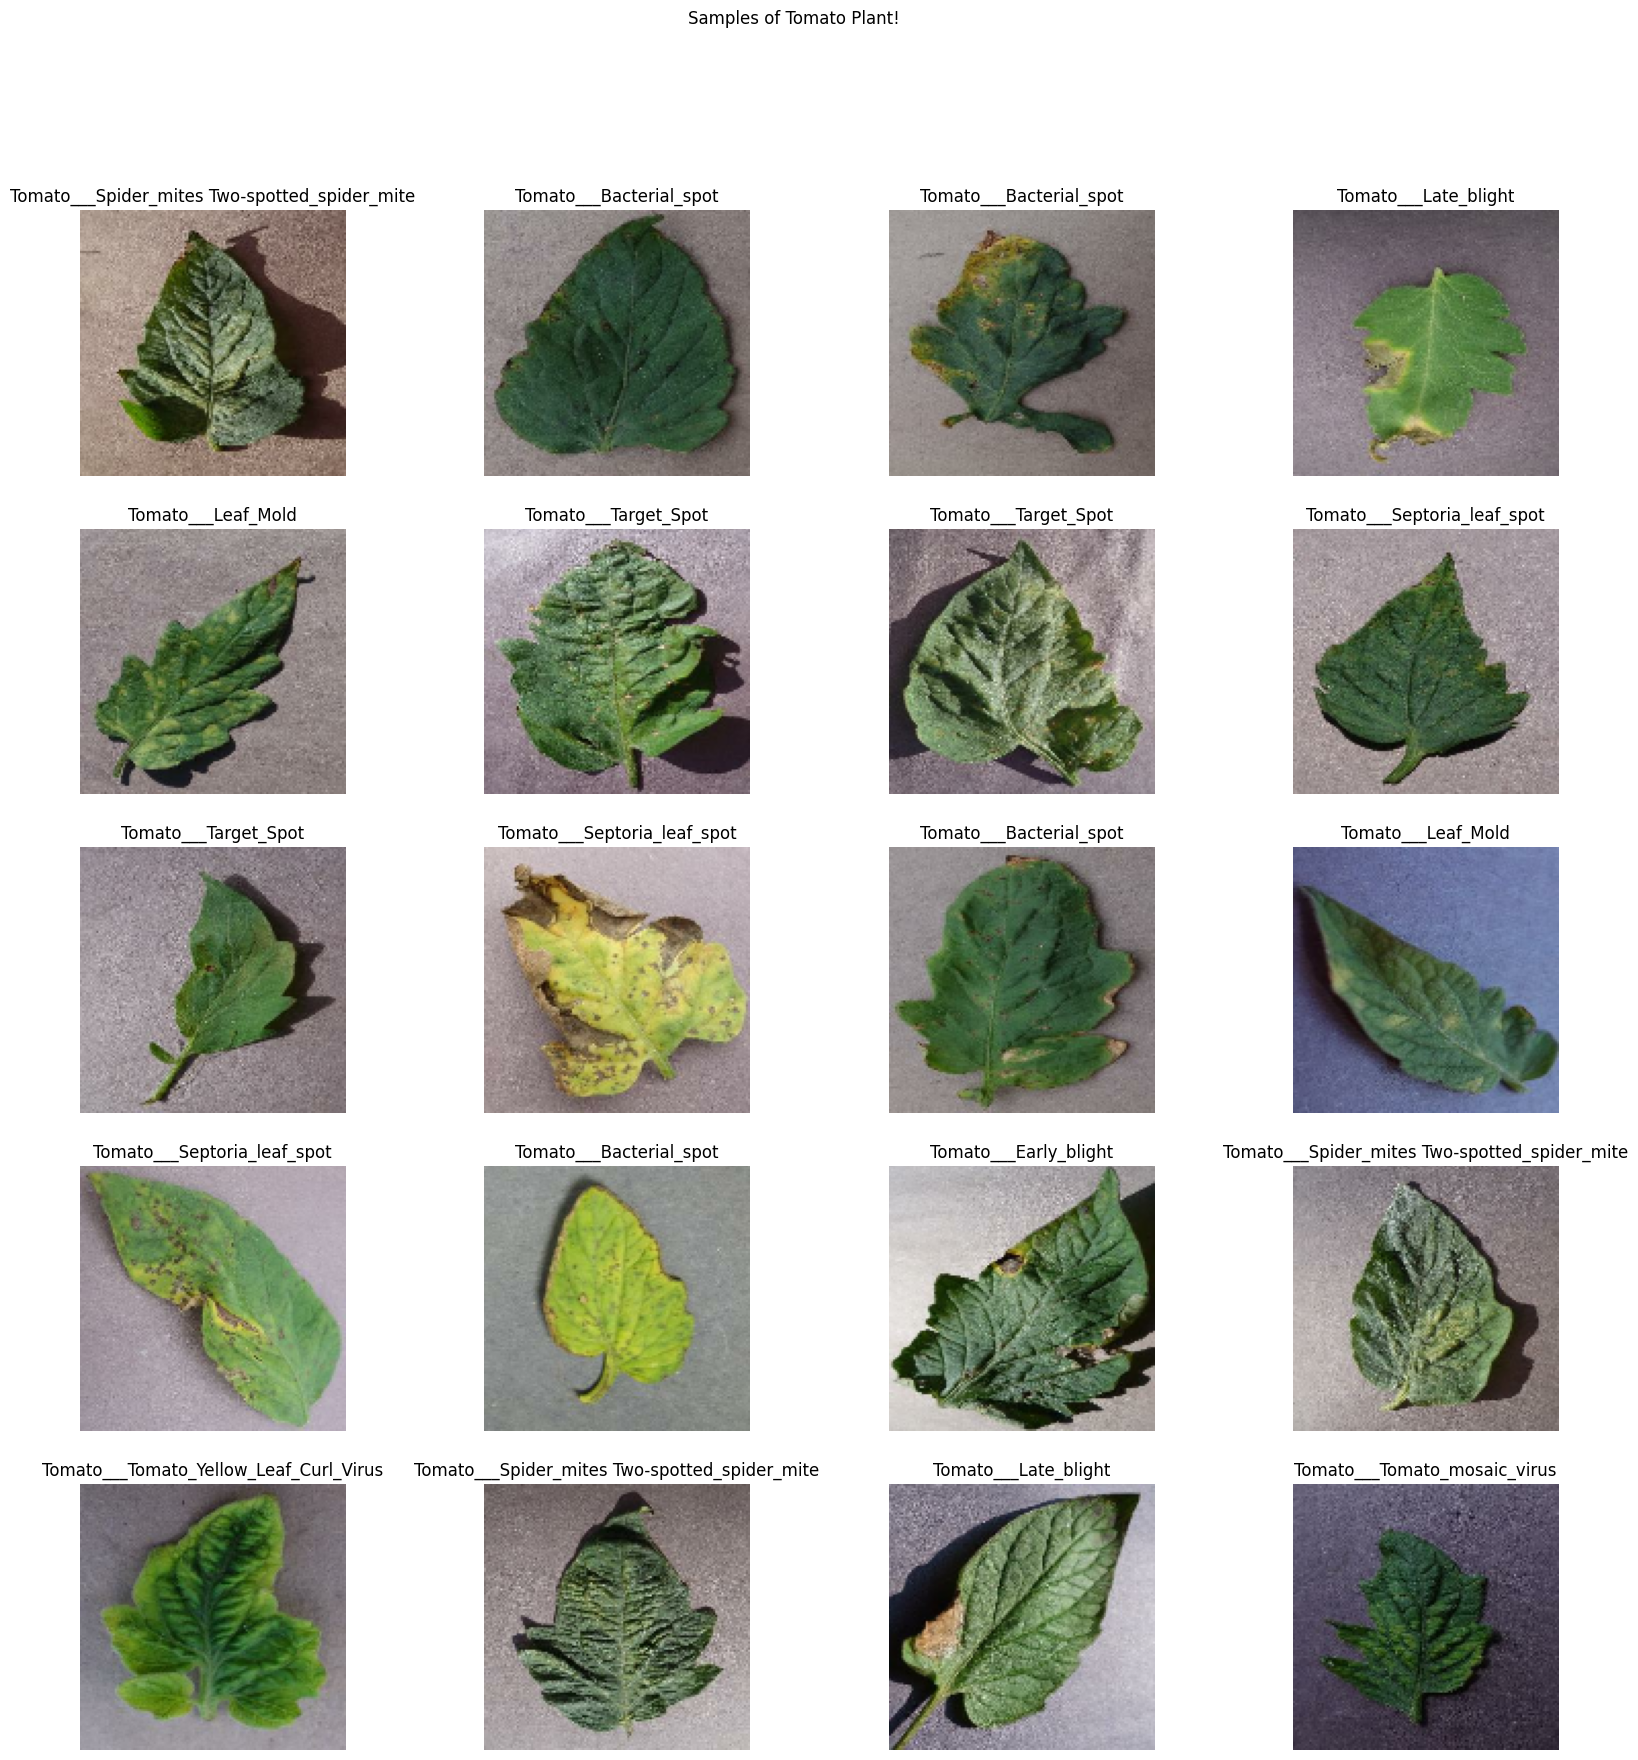

In [5]:
plt.figure(figsize=(20, 20))
plt.suptitle('Samples of Tomato Plant!')
for batch_img,batch_label in training.take(1):
   for i in range(20):
      ax=plt.subplot(5,4,i+1)
      plt.title(classes_name[batch_label[i]])
      plt.imshow(batch_img[i].numpy().astype('uint8'))
      plt.axis('off')

In [6]:
def split_train_val_test(dataset,train_split=0.8,test_split=0.1,val_split=0.1,shuffle=True,shuffle_size=10000):
   assert(train_split+val_split+test_split)==1


   if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    #set size of train,test and val
   train_size=int(train_split*len(dataset))
   val_size=int(val_split*len(dataset))
   test_size=int(test_split*len(dataset))


   train_ds=dataset.take(train_size)
   val_ds=dataset.skip(train_size).take(val_size)
   test_ds=dataset.skip(train_size+val_size).take(test_size)


   return train_ds,val_ds,test_ds

In [7]:
train,val,test=split_train_val_test(training)

In [8]:
train_ds = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [9]:
resize_scaling=tf.keras.Sequential([
    layers.Resizing(IMG_SIZE,IMG_SIZE),
    layers.Rescaling(1./255)
])

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 64)     │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,392 (75.75 KB)

 Trainable params: 19,392 (75.75 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,936,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956,362 (15.09 MB)

 Trainable params: 3,956,362 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Adam is the best among the adaptive optimizers in most of the cases
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# An epoch means training the neural network with all the
# training data for one cycle. Here I use 10 epochs
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, batch_size=BATCH_SIZE,verbose=1)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 133s 479ms/step - accuracy: 0.1639 - loss: 153.7716 - val_accuracy: 0.3004 - val_loss: 2.0082
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 119s 437ms/step - accuracy: 0.4146 - loss: 1.6508 - val_accuracy: 0.5716 - val_loss: 1.3430
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 435ms/step - accuracy: 0.5939 - loss: 1.1846 - val_accuracy: 0.6935 - val_loss: 1.0082
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 438ms/step - accuracy: 0.7062 - loss: 0.8517 - val_accuracy: 0.7631 - val_loss: 0.7524
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 141s 436ms/step - accuracy: 0.8082 - loss: 0.5689 - val_accuracy: 0.8044 - val_loss: 0.6790
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 108s 431ms/step - accuracy: 0.8522 - loss: 0.4407 - val_accuracy: 0.8397 - val_loss: 0.5215
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - accuracy: 0.8894 - loss: 0.3354 - val_accuracy: 0.8105 - val_loss: 0.6090
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 142s 437ms/step - accuracy: 0.8974

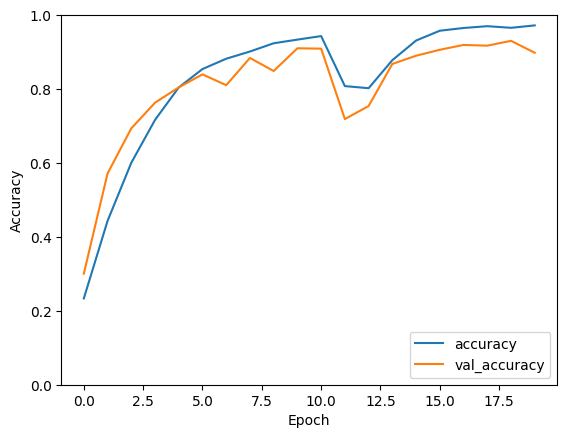

In [15]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')
plt.show()

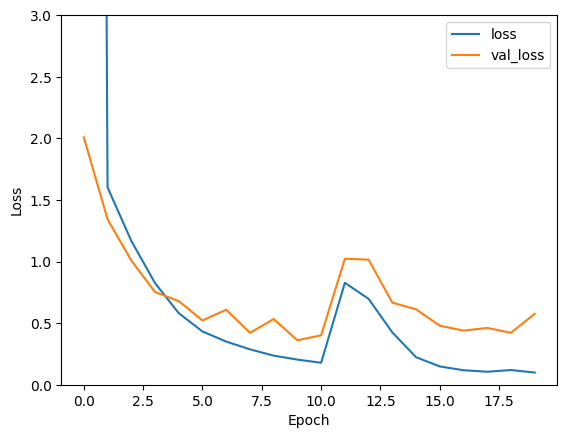

In [16]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.0, 3.0])
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

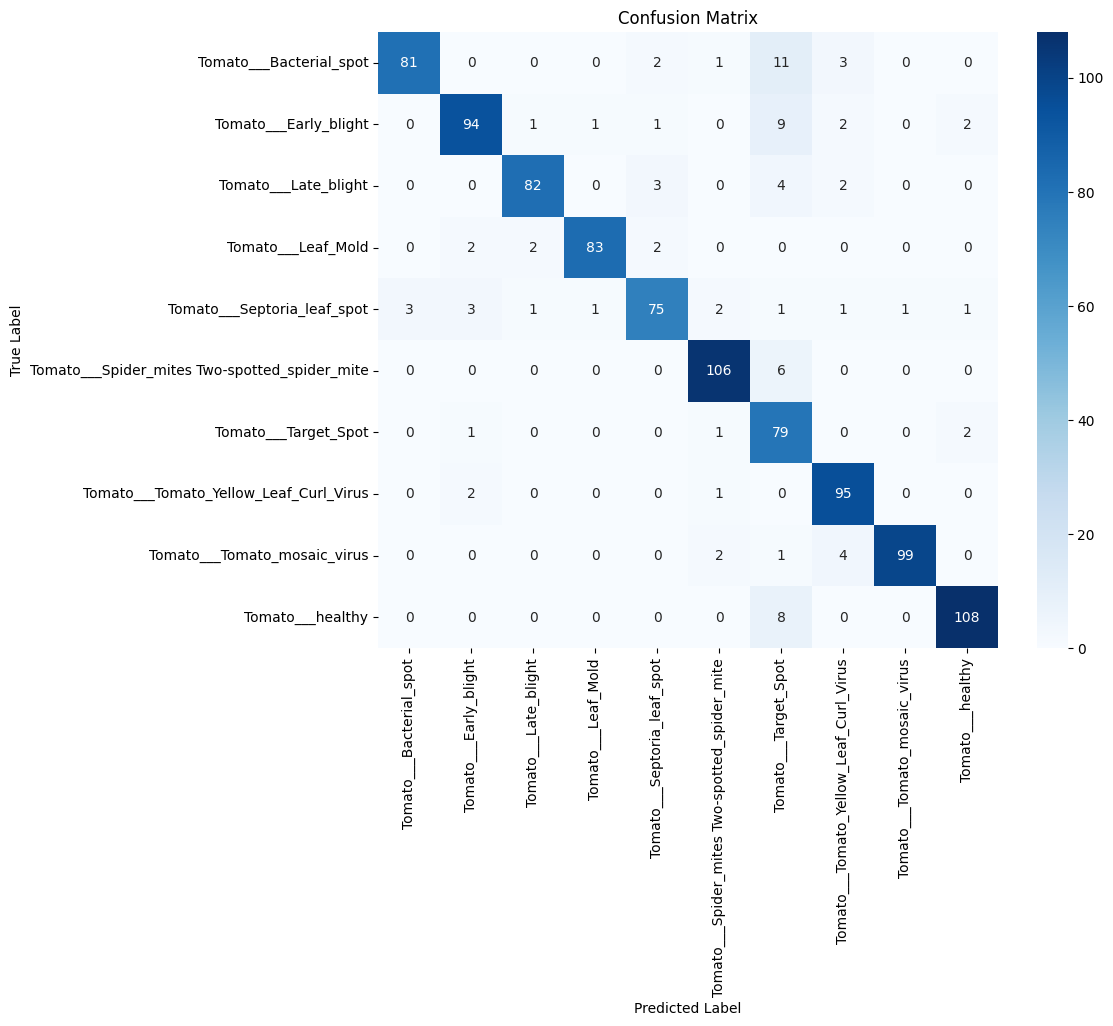

In [17]:

all_true_labels=[]
all_predicted_labels=[]
for image_batch, label_batch in test_ds:
    # Make predictions on the batch
    predictions = model.predict(image_batch)

    # Convert predictions to class indices
    predicted_labels = np.argmax(predictions, axis=1)

    # Convert true labels to numpy array
    true_labels = label_batch.numpy()

    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

# Convert lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_predicted_labels = np.array(all_predicted_labels)
conf_matrix = confusion_matrix(all_true_labels, all_predicted_labels)

    # Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=training.class_names, yticklabels=training.class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig('CNNconfusion.png')
plt.show()


In [18]:
from sklearn.metrics import classification_report
print(classification_report(all_true_labels,all_predicted_labels, target_names=training.class_names))

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.96      0.83      0.89        98
                        Tomato___Early_blight       0.92      0.85      0.89       110
                         Tomato___Late_blight       0.95      0.90      0.93        91
                           Tomato___Leaf_Mold       0.98      0.93      0.95        89
                  Tomato___Septoria_leaf_spot       0.90      0.84      0.87        89
Tomato___Spider_mites Two-spotted_spider_mite       0.94      0.95      0.94       112
                         Tomato___Target_Spot       0.66      0.95      0.78        83
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.89      0.97      0.93        98
                 Tomato___Tomato_mosaic_virus       0.99      0.93      0.96       106
                             Tomato___healthy       0.96      0.93      0.94       116

                                     accu